In [286]:
import cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline
import time

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()
    

In [254]:
# Initialize the parameters

# Confidence threshold 0.5 이하인것은 다 날림.
confThreshold = 0.5 
# Non-maximum suppression threshold 
# 거리가 떨어져 있는것을 하나로 볼것인지 여부. 
# 주변보다 상대적으로 높거나 낮은 것들만 살리고 아닌것들은 버림.
nmsThreshold = 0.4 
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [255]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()] #3개의 yolo 출력층 index 리턴

In [256]:
# print(net.getUnconnectedOutLayers())

# l = net.getLayerNames()

# print(l[200-1])
# print(l[227-1])
# print(l[254-1])

In [257]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

In [258]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:] # 80개의 확률값들 가져오기
            classId = np.argmax(scores) # 가장 높은 확률값 가져오기
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
#     print(len(boxes))
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
#     print(len(indices))
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [277]:
cap = cv2.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

In [278]:
# cap = cv2.VideoCapture('cars.jpg')
# out = net.forward('yolo_82')
# hasFrame, frame = cap.read()

# classIds = []
# confidences = []
# boxes = []
# frameHeight = frame.shape[0]
# frameWidth = frame.shape[1]

# for i in range(len(out)):
#     scores = out[i][5:] # 80개의 확률값들 가져오기
#     classId = np.argmax(scores) # 가장 높은 확률값 가져오기
#     confidence = scores[classId]
#     if confidence > confThreshold :
#         center_x = int(out[i][0] * frameWidth)
#         center_y = int(out[i][1] * frameHeight)
#         width = int(out[i][2] * frameWidth)
#         height = int(out[i][3] * frameHeight)
#         left = int(center_x - width / 2)
#         top = int(center_y - height / 2)
#         classIds.append(classId)
#         confidences.append(float(confidence))
#         boxes.append([left, top, width, height])
        

# print(len(classIds))
# indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
# print(len(indices))
# for i in indices:
#     i = i[0]
#     box = boxes[i]
#     left = box[0]
#     top = box[1]
#     width = box[2]
#     height = box[3]
#     drawPred(classIds[i], confidences[i], left, top, left + width, top + height)
    

# cv2.imwrite("out.png", frame) 
# img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plt.imshow(img)

In [279]:
# print(classIds)
# print(confidences)
# print(boxes)
# print(confidences)

In [280]:
# print(type(outs))
# print(len(outs))

# print(outs[0].shape) #13*13*3
# print(outs[1].shape) #26*26*3
# print(outs[2].shape) #52*52*3

# print(outs[0][0]) # yolo layer1의 0번째 box

In [281]:
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

array([[[241, 230, 219],
        [241, 230, 219],
        [241, 230, 219],
        ...,
        [108, 142, 147],
        [102, 136, 141],
        [ 98, 132, 137]],

       [[241, 230, 219],
        [241, 230, 219],
        [241, 230, 219],
        ...,
        [ 96, 130, 135],
        [ 89, 123, 128],
        [ 85, 119, 124]],

       [[241, 230, 219],
        [241, 230, 219],
        [241, 230, 219],
        ...,
        [ 80, 108, 114],
        [ 73,  98, 105],
        [ 70,  95, 102]],

       ...,

       [[ 76,  88,  99],
        [ 76,  88,  99],
        [ 75,  89,  99],
        ...,
        [ 96,  92,  97],
        [ 96,  92,  97],
        [ 96,  92,  97]],

       [[ 78,  90, 101],
        [ 77,  89, 100],
        [ 76,  90, 100],
        ...,
        [ 95,  91,  96],
        [ 96,  92,  97],
        [ 96,  92,  97]],

       [[ 79,  91, 102],
        [ 78,  90, 101],
        [ 76,  90, 100],
        ...,
        [ 95,  91,  96],
        [ 95,  91,  96],
        [ 96,  92,  97]]

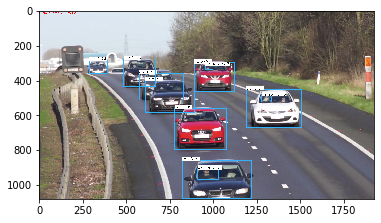

In [282]:
cv2.imwrite("out.png", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [300]:
img1 = cv2.imread('book1.jpg')

fourcc = cv2.VideoWriter_fourcc(*'XVID') # *:arg에 반복자 하나씩 전달해주는 방법
out = cv2.VideoWriter('out.mp4', fourcc, 20, (inpWidth, inpHeight)) # , , 프레임, 크기

cap = cv2.VideoCapture('vtest.avi')

for i in range(10) : 
    hasFrame, frame = cap.read()
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))
    postprocess(frame, outs)
    out.write(frame)
#     imshow('',frame)
#     time.sleep(0.5)

out.release()